### Using Image augmentation to improve performance on image classifier

The dataset comprises 100 food categories, each with ~1000 images. I will initially run a ResNet style model and get a benchmark for classification.

I will then use image augmentation, cropping and mirroring the images to increase the size of the training set to see if this increases performance

In [1]:
import sys
sys.path

['/home/ubuntu/food/food_images_augmentation',
 '/home/ubuntu/.vscode-server/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles',
 '/home/ubuntu/.vscode-server/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles/lib/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/ubuntu/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/home/ubuntu/.ipython']

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
# import plotly
# import plotly.graph_objects as go
# import plotly.express as px
import datetime
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, Flatten, Dense, Activation, Add
import matplotlib.pyplot as plt
from tensorflow.keras import activations
import os
from PIL import ImageOps
from tensorflow.keras.models import Sequential

### Loading the images

The images are a range of sizes, and we'll handle this by converting them all to 128x128, padding the outside where necessary

Initially download using .tar file

In [6]:
#Open image into an 'image' object type
def image_to_vector(file,size=128):
    im_vec = Image.open(file)
    #calculate height and width
    width = im_vec.size[0]
    height = im_vec.size[1]
    #re-size to 1/4 of the size and convert to an array - we've already shown that this doesn't decrease performance
    resize_factor = max(width,height) / 128
    im_vec = np.array(im_vec.resize((int(width//resize_factor),int(height//resize_factor))))
    
    width = im_vec.shape[0]
    height = im_vec.shape[1]
    #Pad it out to a full 128 by 128
    hor_pad_1 = int((size-im_vec.shape[0])/2)
    hor_pad_2 = int((size-im_vec.shape[0]+1)/2)
    ver_pad_1 = int((size - im_vec.shape[1])/2)
    ver_pad_2 = int((size - im_vec.shape[1]+1)/2)
    im_vec = np.pad(im_vec,pad_width=((hor_pad_1,hor_pad_2),(ver_pad_1,ver_pad_2),(0,0)))
    return im_vec

# /home/ubuntu/.keras/datasets/food-101/images/churros/1601.jpg

### We will work with only the opening 3 food categories

In [7]:
'''Load in images of food'''

#go through all the images, put them into vector form, and then have a dictionary where each key is a type of image, and the value is a list of all those vectors.
list_of_food = []
unique_foods = {}
x = np.zeros((3000,128,128,3)).astype(np.uint8)
counter_cats, counter = 0,0
folder = '/Users/jacoblourie/Downloads//Food_Images/Images'
for food_cat in os.listdir(folder)[0:3]:
    print(food_cat)
    #there is a folder called .DS_store which we don't want
    if (food_cat == '.DS_Store'):
        continue
    unique_foods[counter_cats]=food_cat

    for file in os.listdir(f'{folder}/{food_cat}'):
        file_ = f'{folder}/{food_cat}/{file}'
        #here we are resizing
        try:
            im_vec = image_to_vector(file_)
            x[counter] = im_vec.astype(np.uint8)
            # plt.imshow(im_vec)
            list_of_food.append(food_cat)
            counter+=1
        except:
          print(f'{food_cat} had an error')
    counter_cats+=1

foie_gras
club_sandwich
cheese_plate


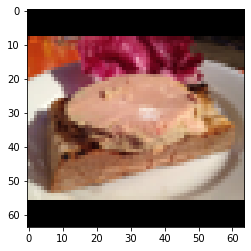

In [178]:
plt.imshow(x[1]); plt.show()

### Creating Y labels and preprocessing the data

In [8]:
#get list of each value in a series with value counts
df = pd.DataFrame(pd.Series(list_of_food).value_counts())
#initialise blank array
y=np.array([])
for food_idx, food in unique_foods.items():
    length =  df.loc[food]
    y  = np.append(y, np.zeros(length)+food_idx)
print(f'Y has {len(y)} numbers')
display(df.T)

Y has 3000 numbers


,club_sandwich,foie_gras,cheese_plate
0,1000,1000,1000


In [123]:
def tts_one_hot(x,y):
    #ensure parallel sizes in case of image errors
    x, y = x[:len(y)], y[:len(y)]

    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.067)

    #normalise x values
    x_train, x_test = x_train/255, x_test/255
    one_hot = OneHotEncoder(sparse = False)

    #create one hot values for y, and reshape to an array
    one_hot_y_train= one_hot.fit_transform(y_train.reshape(-1,1))
    one_hot_y_test= one_hot.fit_transform(y_test.reshape(-1,1))
    return x_train, x_test, y_train, y_test, one_hot_y_train, one_hot_y_test

In [124]:
x_train, x_test, y_train, y_test, one_hot_y_train, one_hot_y_test = tts_one_hot(x,y)

### Base Case ResNet

Initially, I will run a resnet model using this format for inspiration: https://neurohive.io/en/popular-networks/resnet/

In [149]:
class ResNet_20_3():
    #By creating a subclass, we don't need to repeat the train_val_rpedict
    
    #Initialise with the input shape(ignoring examples) and output shape
    def __init__(self, input_dims, output='softmax', classes='False',conv_k_reg=0.001,conv_b_reg=0.001,dense_k_reg=0.001,dense_b_reg=0.001,name='ResNet_512_512_3'): 
        
        #Set regularisers
        self.conv_k_reg = tf.keras.regularizers.L2(conv_k_reg)
        self.conv_b_reg = tf.keras.regularizers.L2(conv_b_reg)
        self.dense_k_reg = tf.keras.regularizers.L2(dense_k_reg)
        self.dense_b_reg = tf.keras.regularizers.L2(dense_b_reg)

        self.input_im = Input(shape=(input_dims))
        
        #start with a layer non resnet
        x = Conv2D(64,kernel_size=(7,7),padding='valid',strides=(2,2), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(self.input_im)
        x = Activation(activations.relu)(x)
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2))(x)
        #2 non pool ones
        for i in range(3):
            x = self._resnet_layer(x)
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2))(x)    
        for i in range(3):
            x = self._resnet_layer(x,filters=(128,128))
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2))(x)   
        for i in range(3):
            x = self._resnet_layer(x,filters=(256,256))
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2))(x)           
        for i in range(3):
            x = self._resnet_layer(x,filters=(512,512))
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(1,1))(x)    
        x = Flatten()(x)
        x = Dense(200,activation='relu',kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        x = Dense(200,activation='relu',kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        activation = output
        if output == 'sigmoid':
            classes = 1
        x = Dense(classes, activation=activation,kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        self.model = Model(inputs = self.input_im, outputs= x,name=name)



    def _resnet_layer(self,x, first_kernel=(3,3),second_kernel=(3,3), filters=(64,64)):
        f1,f2=filters
        #do one full layer convolution, with activation
        x_skip = x
        #do another 2 layers for the x that you're passing through the longer loops
        x = Conv2D(f1, kernel_size=first_kernel,activation='relu',padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)
        x = Conv2D(f2, kernel_size=second_kernel,activation='relu',padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)        
        #conv the skip
        x_ = Conv2D(f2, kernel_size=(1,1),padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x_skip)
        
        #add them back to together
        x = Add()([x,x_])
        #activation both of them
        x = Activation(activations.relu)(x)        
        return x
    
    def train_test_predict(self,x_train,y_train,x_test,y_test):
        preds_train  = np.argmax(self.model.predict(x_train),axis=-1)
        preds_test = np.argmax(self.model.predict(x_test),axis=-1)
        self.current_train_prediction_score = {np.sum(y_train - preds_train == 0)/x_train.shape[0]}
        self.current_test_prediction_score = {np.sum(y_test - preds_test == 0)/x_test.shape[0]}
        print(f'train prediction percentage is {self.current_train_prediction_score}')
        print(f'test prediction percentage is {self.current_test_prediction_score}')

'''Other helper function'''
#Plotting the accuracy of a second val set, and the historic performance of the validations et.
def plot_accs(training_object):
    val_acc, train_acc = training_object.history['val_acc'], training_object.history['acc']
    x = np.linspace(1,len(val_acc),len(val_acc))
    fig = plt.figure()
    plt.plot(x,val_acc) #= go.Scatter(x=x,y=val_acc,name='val_acc'), 
    plt.plot(x,train_acc) # ,name='train_acc')
    plt.legend(('val_acc','train_acc'))
    #     fig.add_trace(line_1)
#     fig.add_trace(line_2)
    fig.show()

In [125]:
resnet_8 = ResNet_20_3((128,128,3),classes=3,conv_k_reg=0.001, conv_b_reg=0.001, dense_b_reg=0.01, dense_k_reg= 0.01)
resnet_8.model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='acc')
resnet_8.model.summary()

Model: "ResNet_512_512_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_555 (Conv2D)             (None, 61, 61, 64)   9472        input_18[0][0]                   
__________________________________________________________________________________________________
activation_195 (Activation)     (None, 61, 61, 64)   0           conv2d_555[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_75 (MaxPooling2D) (None, 30, 30, 64)   0           activation_195[0][0]             
___________________________________________________________________________________

In [126]:
'''Define callbacks tosave model'''
checkpoint_path = "basic_mod/weights{epoch:04d}"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [127]:
'''fit the model'''
training_object = resnet_8.model.fit(x_train,one_hot_y_train,epochs=40,batch_size=30, validation_split = 0.15,validation_batch_size=300,callbacks=[cp_callback])
# resnet_8.train_test_predict(x_train,y_train,x_test[:5000],y_test[:5000])
# plot_accs(training_object)

Epoch 1/40
80/80 [==============================] - 108s 1s/step - loss: 186.6242 - acc: 0.3515 - val_loss: 20.4516 - val_acc: 0.4214

Epoch 00001: saving model to basic_mod/weights0001
Epoch 2/40
80/80 [==============================] - 114s 1s/step - loss: 19.9523 - acc: 0.4681 - val_loss: 18.8364 - val_acc: 0.5095

Epoch 00002: saving model to basic_mod/weights0002
Epoch 3/40
80/80 [==============================] - 116s 1s/step - loss: 18.5057 - acc: 0.5507 - val_loss: 17.7797 - val_acc: 0.5810

Epoch 00003: saving model to basic_mod/weights0003
Epoch 4/40
80/80 [==============================] - 110s 1s/step - loss: 17.5309 - acc: 0.6087 - val_loss: 17.2579 - val_acc: 0.4357

Epoch 00004: saving model to basic_mod/weights0004
Epoch 5/40
80/80 [==============================] - 109s 1s/step - loss: 16.8076 - acc: 0.6055 - val_loss: 16.5372 - val_acc: 0.5095

Epoch 00005: saving model to basic_mod/weights0005
Epoch 6/40
80/80 [==============================] - 121s 2s/step - loss: 1

##### This overfits significantly. Let's increase conv_k and conv_b regularisation in order to overcome this

In [131]:
resnet_8_r = ResNet_20_3((128,128,3),classes=3,conv_k_reg=0.005, conv_b_reg=0.005, dense_b_reg=0.01, dense_k_reg= 0.01)
resnet_8_r.model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='acc')
resnet_8_r.model.summary()

Model: "ResNet_512_512_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_629 (Conv2D)             (None, 61, 61, 64)   9472        input_20[0][0]                   
__________________________________________________________________________________________________
activation_221 (Activation)     (None, 61, 61, 64)   0           conv2d_629[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_85 (MaxPooling2D) (None, 30, 30, 64)   0           activation_221[0][0]             
___________________________________________________________________________________

In [132]:
checkpoint_path_r = "basic_mod/weights{epoch:04d}"
checkpoint_dir_r = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback_r = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_r,
                                                 save_weights_only=True,
                                                 verbose=1)

In [133]:
training_object_r = resnet_8_r.model.fit(x_train,one_hot_y_train,epochs=40,batch_size=30, validation_split = 0.15,validation_batch_size=300,callbacks=[cp_callback_r])

Epoch 1/40
80/80 [==============================] - 118s 1s/step - loss: 596.0386 - acc: 0.3343 - val_loss: 73.6147 - val_acc: 0.3381

Epoch 00001: saving model to basic_mod/weights0001
Epoch 2/40
80/80 [==============================] - 114s 1s/step - loss: 71.7373 - acc: 0.4098 - val_loss: 67.1363 - val_acc: 0.4595

Epoch 00002: saving model to basic_mod/weights0002
Epoch 3/40
80/80 [==============================] - 113s 1s/step - loss: 65.9550 - acc: 0.4833 - val_loss: 62.9015 - val_acc: 0.4167

Epoch 00003: saving model to basic_mod/weights0003
Epoch 4/40
80/80 [==============================] - 108s 1s/step - loss: 61.9555 - acc: 0.5494 - val_loss: 59.5386 - val_acc: 0.5071

Epoch 00004: saving model to basic_mod/weights0004
Epoch 5/40
80/80 [==============================] - 106s 1s/step - loss: 58.7567 - acc: 0.5696 - val_loss: 56.7700 - val_acc: 0.5119

Epoch 00005: saving model to basic_mod/weights0005
Epoch 6/40
80/80 [==============================] - 119s 1s/step - loss: 5

#### We have a benchmark validation score of ~60%
We could possibly tune the model and get a slightly higher score, but our training data has only 640 image after partitioning samples for validation and test set, which will limit the performance we can achieve.

train prediction percentage is {0.7106109324758842}
test prediction percentage is {0.572139303482587}


<ipython-input-149-4ae7649b19aa>:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


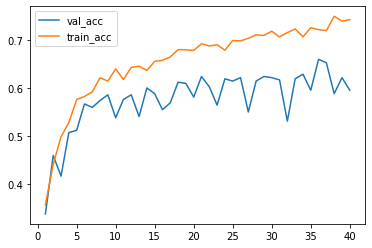

In [150]:
'''Plot accuracy and also run on test set'''
resnet_8_r.train_test_predict(x_train,y_train,x_test[:],y_test[:])
plot_accs(training_object_r)


## Image Processing

There are typically four ways to increase the size of our dataset through image augmentation:

1) Rotating the image

2) Distorting the colors by changing the RGB values very slightly 

3) Cropping the image

4) Mirroring the image 

I will initially focus on cropping and mirroring, which intuitively are likely to lead to limit the number of poor quality new images that we generate. I will then try distortions, and then rotations.

The general approach will be to create a mirror image for each image (2 images total), and then 5 crops for each image (10 images). Once we add 5 distortions per image (50 images total), and 4 minor rotations (200 images per initial image), our dataset will have grown 200x, from 20000 imagess to 4,000,000 images

### The following four functions allow us to mirror, crop, resize and label our images

In [85]:
def create_five_images(image,crop=0.85):
    
    #create a mirror
    image_mirror= ImageOps.mirror(image)
    
    '''helper function to crop both the image and mirror image'''
    def get_crops(x,crop=crop):
        #create coordinates for height, cropped height and the height removed (+width)
        orig_w = x.size[0]
        orig_h = x.size[1]
        crop_w = int(crop*orig_w)
        crop_h = int(crop*orig_h)
        w_rem = orig_w - crop_w
        h_rem = orig_h - crop_h

        #create 5 crops
        x_tl_crp = x.crop((0,0,crop_w,crop_h))
        x_tr_crp = x.crop((w_rem,0,orig_w,crop_h))
        x_bl_crp = x.crop((0,h_rem,crop_h,orig_h))
        x_br_crp = x.crop((w_rem, h_rem, orig_w, orig_h))
        x_mid_crp = x.crop((int(w_rem/2),int(h_rem/2),int(orig_w-w_rem/2),int(orig_h-h_rem/2)))
        return x_tl_crp, x_tr_crp, x_bl_crp, x_br_crp, x_mid_crp

    #call this function for both image and mirror image
    tupee = tuple(get_crops(image) + tuple(get_crops(image_mirror)))
    return tupee


In [86]:
def create_multiple_images(file,size):
    #load image
    pil_im = Image.open(file)

    #call function to create ten images
    tuple_of_ims = create_five_images(pil_im)
    #create blank list to store them 
    list_of_same_im = []
    
    '''loop through tuple of ten images in order to resize them'''
    for im in tuple_of_ims:
        #create height, width, and the coefficient to downscale it.
        width = im.size[0]
        height = im.size[1]
        re_size_val = max(width,height)/size

        im_vec = np.array(im.resize((int(width//re_size_val),int(height//re_size_val))))
        #Pad it out to a full 128 by 128
        hor_pad_1 = int((size-im_vec.shape[0])/2)
        hor_pad_2 = int((size-im_vec.shape[0]+1)/2)
        ver_pad_1 = int((size - im_vec.shape[1])/2)
        ver_pad_2 = int((size - im_vec.shape[1]+1)/2)
        im_vec = np.pad(im_vec,pad_width=((hor_pad_1,hor_pad_2),(ver_pad_1,ver_pad_2),(0,0)))
        list_of_same_im.append(im_vec)
        
    return list_of_same_im

In [91]:
def create_x_values(cur_folder,new_folder,sub_folders=3,size=128,start=0,end=2000):

    list_of_food = []
    unique_foods = {}
    x = np.zeros((size,size,3)).astype(np.uint8)
    counter_cats, counter =0,0
    for food_cat in os.listdir(cur_folder)[0:sub_folders]:
        if not os.path.isdir(f'{new_folder}/{food_cat}'):
            os.mkdir(f'{new_folder}/{food_cat}')
        if (food_cat == '.DS_Store') or (food_cat == 'waffles'):
            continue
        unique_foods[counter_cats]=food_cat

        for file in os.listdir(f'{cur_folder}/{food_cat}')[start:end]:
            file_ = f'{cur_folder}/{food_cat}/{file}'

            #here we are resizing and adding to the array
#             try:
            list_of_ten_images_in_vec = create_multiple_images(file_,size=size)
            for i in list_of_ten_images_in_vec:
                file_to_save = i.astype(np.uint8)
                image_to_save = Image.fromarray(file_to_save)

                with open(f'{new_folder}/{food_cat}/img{counter}.jpg','wb+') as f:
                    image_to_save.save(f)
                counter+=1
                list_of_food.append(food_cat)
#             except:
#                 print(f'{food_cat} had an error')
#                 print(counter)
                
        counter_cats+=1
    return list_of_food, unique_foods

#### We can now load the images in

In [102]:
cur_folder = '/Users/jacoblourie/Downloads/Food_Images/Images'
train_folder = '/Users/jacoblourie/computer_vision/food_images_aug/train'
test_folder = '/Users/jacoblourie/computer_vision/food_images_aug/test'
list_of_food_mircrop, unique_foods_mircrop = create_x_values(cur_folder,train_folder,end=800)
list_of_food_mircrop, unique_foods_mircrop = create_x_values(cur_folder,test_folder,start=800)
# y_mir_crop = get_y_values(list_of_food_mircrop, unique_foods_mircrop)

##### Processing them with Tensorflow datasets preprocessing

In [113]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_folder,
#   validation_split=0,
#   subset="training",
  seed=123,
  image_size=(128, 128),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_folder,
  validation_split=0.3,
  subset="training",  
  seed=123,
  image_size=(128, 128),
  batch_size=32)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_folder,
  validation_split=0.3,
  subset="validation",  
  seed=123,
  image_size=(128, 128),
  batch_size=32)

Found 24000 files belonging to 3 classes.
Found 6000 files belonging to 3 classes.
Using 4200 files for training.
Found 6000 files belonging to 3 classes.
Using 1800 files for validation.


In [114]:
print(train_ds.class_names)
print(test_ds.class_names)
print(val_ds.class_names)

['cheese_plate', 'club_sandwich', 'foie_gras']
['cheese_plate', 'club_sandwich', 'foie_gras']
['cheese_plate', 'club_sandwich', 'foie_gras']


In [115]:
#this section creates caching and pre-fetching for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [116]:
def pre_processing(x,binary='yes'):

    #flip between -30' and 30'
    x = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128,128,3))(x)
    if binary == 'yes':
        x = tf.image.random_saturation(x,0,0.25)
        x = tf.image.random_hue(x,0.1)
        x = layers.experimental.preprocessing.RandomRotation(0.08333)(x)
    else:
        x = tf.image.random_saturation(x,0,0.0001)
        x = tf.image.random_hue(x,0.00001)
        x = layers.experimental.preprocessing.RandomRotation(0.000001)(x)
    return x

In [117]:
class Resnet_w_pp():
    #By creating a subclass, we don't need to repeat the train_val_rpedict
    
    #Initialise with the input shape(ignoring examples) and output shape
    def __init__(self, input_dims,pp='yes', output='softmax', classes='False',conv_k_reg=0.001,conv_b_reg=0.001,dense_k_reg=0.001,dense_b_reg=0.001,name='ResNet_512_512_3'): 
        
        #Set regularisers
        self.conv_k_reg = tf.keras.regularizers.L2(conv_k_reg)
        self.conv_b_reg = tf.keras.regularizers.L2(conv_b_reg)
        self.dense_k_reg = tf.keras.regularizers.L2(dense_k_reg)
        self.dense_b_reg = tf.keras.regularizers.L2(dense_b_reg)

        self.input_im = Input(shape=(input_dims))
        
        #start with a layer non resnet

        x = pre_processing(self.input_im,binary=pp)
        x = Conv2D(64,kernel_size=(7,7),padding='valid',strides=(2,2), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)
        x = Activation(activations.relu)(x)
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2))(x)
        #2 non pool ones
        for i in range(3):
            x = self._resnet_layer(x)
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2))(x)    
        for i in range(3):
            x = self._resnet_layer(x,filters=(128,128))
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2))(x)   
        for i in range(3):
            x = self._resnet_layer(x,filters=(256,256))
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2))(x)           
        for i in range(3):
            x = self._resnet_layer(x,filters=(512,512))
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(1,1))(x)    
        x = Flatten()(x)
        x = Dense(200,activation='relu',kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        x = Dense(200,activation='relu',kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        activation = output
        if output == 'sigmoid':
            classes = 1
        x = Dense(classes, activation=activation,kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        self.model = Model(inputs = self.input_im, outputs= x,name=name)



    def _resnet_layer(self,x, first_kernel=(3,3),second_kernel=(3,3), filters=(64,64)):
        f1,f2=filters
        #do one full layer convolution, with activation
        x_skip = x
        #do another 2 layers for the x that you're passing through the longer loops
        x = Conv2D(f1, kernel_size=first_kernel,activation='relu',padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)
        x = Conv2D(f2, kernel_size=second_kernel,activation='relu',padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)        
        #conv the skip
        x_ = Conv2D(f2, kernel_size=(1,1),padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x_skip)
        
        #add them back to together
        x = Add()([x,x_])
        #activation both of them
        x = Activation(activations.relu)(x)        
        return x
    
    def train_test_predict(self,x_train,y_train,x_test,y_test):
        preds_train  = np.argmax(self.model.predict(x_train),axis=-1)
        preds_test = np.argmax(self.model.predict(x_test),axis=-1)
        self.current_train_prediction_score = {np.sum(y_train - preds_train == 0)/x_train.shape[0]}
        self.current_test_prediction_score = {np.sum(y_test - preds_test == 0)/x_test.shape[0]}
        print(f'train prediction percentage is {self.current_train_prediction_score}')
        print(f'test prediction percentage is {self.current_test_prediction_score}')

'''Other helper function'''
#Plotting the accuracy of a second val set, and the historic performance of the validations et.
def plot_accs(training_object):
    val_acc, train_acc = training_object.history['val_acc'], training_object.history['acc']
    x = np.linspace(1,len(val_acc),len(val_acc))
    fig = plt.figure()
    plt.scatter(x,val_acc,) #= go.Scatter(x=x,y=val_acc,name='val_acc'), 
    plt.scatter(x=x,y=train_acc) # ,name='train_acc')
    plt.legend(('val_acc','train_acc'))
    #     fig.add_trace(line_1)
#     fig.add_trace(line_2)
    fig.show()

In [118]:
Res_pp = Resnet_w_pp(input_dims = (128,128,3),classes=3)
Res_pp.model.compile(optimizer='adam',metrics='acc',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))

In [119]:
Res_pp.model.summary()

Model: "ResNet_512_512_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling_13 (Rescaling)        (None, 128, 128, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
tf.image.adjust_saturation_12 ( (None, 128, 128, 3)  0           rescaling_13[0][0]               
__________________________________________________________________________________________________
tf.image.adjust_hue_12 (TFOpLam (None, 128, 128, 3)  0           tf.image.adjust_saturation_12[0][
___________________________________________________________________________________

In [120]:
checkpoint_path_pp = "pp_mod/weights{epoch:04d}"
checkpoint_dir_pp = os.path.dirname(checkpoint_path_pp)

# Create a callback that saves the model's weights
cp_callback_ = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_pp,
                                                 save_weights_only=True,
                                                 verbose=1)

In [121]:
training_object_pp = Res_pp.model.fit(train_ds,validation_data = val_ds,epochs=25, batch_size = 30,validation_batch_size=150,callbacks=[cp_callback_])

Epoch 1/25
750/750 [==============================] - 1355s 2s/step - loss: 42.6029 - acc: 0.4054 - val_loss: 12.9002 - val_acc: 0.5679

Epoch 00001: saving model to pp_mod/weights0001
Epoch 2/25
750/750 [==============================] - 1359s 2s/step - loss: 12.3632 - acc: 0.5233 - val_loss: 10.7901 - val_acc: 0.6245

Epoch 00002: saving model to pp_mod/weights0002
Epoch 3/25
750/750 [==============================] - 1279s 2s/step - loss: 10.4408 - acc: 0.5774 - val_loss: 9.2066 - val_acc: 0.6410

Epoch 00003: saving model to pp_mod/weights0003
Epoch 4/25
750/750 [==============================] - 960s 1s/step - loss: 8.9037 - acc: 0.6154 - val_loss: 7.8715 - val_acc: 0.6421

Epoch 00004: saving model to pp_mod/weights0004
Epoch 5/25
750/750 [==============================] - 1015s 1s/step - loss: 7.5753 - acc: 0.6468 - val_loss: 6.6777 - val_acc: 0.6676

Epoch 00005: saving model to pp_mod/weights0005
Epoch 6/25
750/750 [==============================] - 1024s 1s/step - loss: 6.429

In [134]:
training_object_pp2 = Res_pp.model.fit(train_ds,validation_data = val_ds,epochs=25, batch_size = 30,validation_batch_size=150,callbacks=[cp_callback_])

Epoch 1/25
750/750 [==============================] - 1192s 2s/step - loss: 0.8033 - acc: 0.7389 - val_loss: 0.8961 - val_acc: 0.7052

Epoch 00001: saving model to pp_mod/weights0001
Epoch 2/25
750/750 [==============================] - 1075s 1s/step - loss: 0.7999 - acc: 0.7372 - val_loss: 0.8194 - val_acc: 0.7374

Epoch 00002: saving model to pp_mod/weights0002
Epoch 3/25
750/750 [==============================] - 1092s 1s/step - loss: 0.7963 - acc: 0.7383 - val_loss: 0.8089 - val_acc: 0.7431

Epoch 00003: saving model to pp_mod/weights0003
Epoch 4/25
750/750 [==============================] - 1110s 1s/step - loss: 0.7871 - acc: 0.7452 - val_loss: 0.8143 - val_acc: 0.7364

Epoch 00004: saving model to pp_mod/weights0004
Epoch 5/25
750/750 [==============================] - 1094s 1s/step - loss: 0.7876 - acc: 0.7434 - val_loss: 0.8060 - val_acc: 0.7317

Epoch 00005: saving model to pp_mod/weights0005
Epoch 6/25
750/750 [==============================] - 1046s 1s/step - loss: 0.7743 - 

Training and Val performance from first 25 epochs:


<ipython-input-149-4ae7649b19aa>:78: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


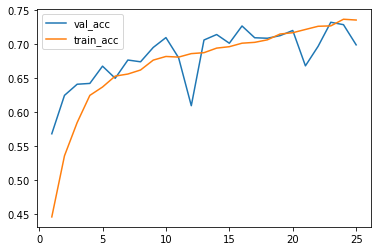

In [151]:
print('Training and Val performance from first 25 epochs:')
plot_accs(training_object_pp)

#### Run on train set

We need to load another instance of the model without the preprocessing steps (Tf doesn't automatically handle this for tf.image... library

In [135]:
Res_pptest = Resnet_w_pp(input_dims = (128,128,3),classes=3,pp='no')
Res_pptest.model.compile(optimizer='adam',metrics='acc',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))

In [136]:
latest = tf.train.latest_checkpoint(checkpoint_dir_pp)

In [138]:
Res_pptest.model.load_weights(latest)

In [153]:
preds = Res_pptest.model.evaluate(test_ds)

57/57 [==============================] - 16s 257ms/step - loss: 0.8562 - acc: 0.7140


### 71.4% on test set, versus 57% without image augmentation!